In [7]:
%matplotlib inline 
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.lstm_1 = nn.LSTM(self.input_size, self.hidden_size)
        self.lstm_2 = nn.LSTM(self.hidden_size, self.hidden_size)
        self.lstm_3 = nn.LSTM(self.hidden_size, self.hidden_size)
        self.lstm_4 = nn.LSTM(self.hidden_size, self.hidden_size)
        self.lstm_5 = nn.LSTM(self.hidden_size, self.hidden_size)
        self.lstm_6 = nn.LSTM(self.hidden_size, self.hidden_size)
        self.lstm_7 = nn.LSTM(self.hidden_size, self.hidden_size)
        
        self.out = nn.Linear(self.hidden_size, self.output_size)
          
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input, ch_1, ch_2, ch_3, ch_4, ch_5, ch_6, ch_7):
        (hidden_1, cell_1), (hidden_2, cell_2), (hidden_3, cell_3), (hidden_4, cell_4), (hidden_5, cell_5) = ch_1, ch_2, ch_3, ch_4, ch_5
        (hidden_6, cell_6), (hidden_7, cell_7) = ch_6, ch_7
        
        
        output, (hidden_1, cell_1) = self.lstm_1(input.view(1,1,-1).float(), (hidden_1, cell_1))
        output_1 = output
        
        output, (hidden_2, cell_2) = self.lstm_2(output, (hidden_2, cell_2))
        output_2 = output
        
        output, (hidden_3, cell_3) = self.lstm_3(output + output_1, (hidden_3, cell_3)) # skip_connection 1
        output_3 = output
        
        output, (hidden_4, cell_4) = self.lstm_4(output + output_2, (hidden_4, cell_4)) # skip_connection 2
        output_4 = output
        
        output, (hidden_5, cell_5) = self.lstm_5(output + output_3, (hidden_5, cell_5)) # skip_connection 3
        output_5 = output
        
        output, (hidden_6, cell_6) = self.lstm_6(output + output_4, (hidden_6, cell_6)) # skip_connection 4
        
        output, (hidden_7, cell_7) = self.lstm_7(output + output_5, (hidden_7, cell_7)) # skip_connection 5
        
        output = self.out(output[0])
        #output = self.softmax(output)
        return output, (hidden_1, cell_1),(hidden_2, cell_2),(hidden_3, cell_3),(hidden_4, cell_4),(hidden_5, cell_5),(hidden_6, cell_6),(hidden_7, cell_7)
    
    def init_hidden(self):
        return torch.rand((1, 1, self.hidden_size), device=device)/100
    
    def init_cell(self):
        return torch.rand((1, 1, self.hidden_size), device=device)/100
    
    
print(torch.cuda.is_available())



""" 
NOTE: 
Encoder RNN input of size (Sentence_length * input_feature)
Encoder RNN output of size (1 * 1 * hidden_size)  should be (num_sentences * 1 * hidden_size)

Decoder RNN input of size 0 (scalar value)
Decoder RNN output of size (1 * target_num)   should be (num_sentences * target_num)
"""

True


' \nNOTE: \nEncoder RNN input of size (Sentence_length * input_feature)\nEncoder RNN output of size (1 * 1 * hidden_size)  should be (num_sentences * 1 * hidden_size)\n\nDecoder RNN input of size 0 (scalar value)\nDecoder RNN output of size (1 * target_num)   should be (num_sentences * target_num)\n'

In [84]:

# load data from file
"""with open("/home/yiqin/2018summer_project/DeepMusic/pitch_data.pkl", "rb") as f:
    dic = pickle.load(f)
    train_X = dic["X"]
    #train_Y = dic["Y"]
    #time_X = dic["time"]
    """
    
with open("/home/yiqin/2018summer_project/data/smooth_data.pkl", "rb") as f:
    dic = pickle.load(f)
    train_X = dic["X"]
    train_Y = dic["Y"]
    
    
target_Tensor = train_Y
maximum_target = len(train_Y)

In [2]:
def evaluate(decoder, test_X):
    if type(test_X.size) is int: 
        input_length = test_X.size
    else:
        input_length = test_X.size(0)
    
    loss = 0
        
    hidden_1 = decoder.init_hidden()
    hidden_2 = decoder.init_hidden()
    hidden_3 = decoder.init_hidden()
    hidden_4 = decoder.init_hidden()
    hidden_5 = decoder.init_hidden()
    hidden_6 = decoder.init_hidden()
    hidden_7 = decoder.init_hidden()
    cell_1 = decoder.init_cell()
    cell_2 = decoder.init_cell()
    cell_3 = decoder.init_cell()
    cell_4 = decoder.init_cell()
    cell_5 = decoder.init_cell()
    cell_6 = decoder.init_cell()
    cell_7 = decoder.init_cell()
    
    temp = []
    temp_score = []
    
    decoder_input = test_X[0]
    
    for di in range(0, input_length):
        decoder_output, (hidden_1, cell_1), (hidden_2, cell_2), (hidden_3, cell_3),  (hidden_4, cell_4), (hidden_5, cell_5), (hidden_6, cell_6), (hidden_7, cell_7) = decoder(decoder_input, 
                        (hidden_1, cell_1), (hidden_2, cell_2), (hidden_3, cell_3), (hidden_4, cell_4), (hidden_5, cell_5), (hidden_6, cell_6), (hidden_7, cell_7))
        output = float(decoder_output.data.cpu().numpy())
        temp.append(str('%.4f'%output))
        if di + 1 < input_length:
            decoder_input = test_X[di+1]

    return np.array(temp)

In [3]:
input_size = 2
hidden_size = 256
output_size = 1

model = DecoderRNN(input_size, hidden_size, output_size).to(device)

model.load_state_dict(torch.load("lstm_smooth_train.pt"))
print(model)

DecoderRNN(
  (lstm_1): LSTM(2, 256)
  (lstm_2): LSTM(256, 256)
  (lstm_3): LSTM(256, 256)
  (lstm_4): LSTM(256, 256)
  (lstm_5): LSTM(256, 256)
  (lstm_6): LSTM(256, 256)
  (lstm_7): LSTM(256, 256)
  (out): Linear(in_features=256, out_features=1, bias=True)
  (softmax): Softmax()
)


In [5]:
print(evaluate(model, train_X[15001].to(device)))
print(train_Y[15001].numpy())

['0.5052' '0.2680' '0.2123' '0.2615' '0.6575' '0.3456' '0.2443' '0.1208'
 '0.2671' '0.2712' '0.5836' '0.3614' '0.7295' '0.4606' '0.3404' '0.1747'
 '0.2724' '0.3518' '0.9019']
[ 0.5    0.25   0.25   0.5    1.     0.5    0.25   0.125  0.125  0.125
  0.25   0.5    1.     0.5    0.25   0.25   0.25   0.5    1.   ]


In [9]:
def validate(decoder, val_x, val_y, val_threshold = 0.5):

    hidden_1 = decoder.init_hidden()
    hidden_2 = decoder.init_hidden()
    hidden_3 = decoder.init_hidden()
    hidden_4 = decoder.init_hidden()
    hidden_5 = decoder.init_hidden()
    hidden_6 = decoder.init_hidden()
    hidden_7 = decoder.init_hidden()
    cell_1 = decoder.init_cell()
    cell_2 = decoder.init_cell()
    cell_3 = decoder.init_cell()
    cell_4 = decoder.init_cell()
    cell_5 = decoder.init_cell()
    cell_6 = decoder.init_cell()
    cell_7 = decoder.init_cell()
    
    temp = []
    temp_score = []
    count = 0
    total = 0
    for i in range(len(val_x)):
        X = val_x[i].to(device)
        val_input = X[0]
        input_length = X.size(0)
        for di in range(0, input_length):
            decoder_output, (hidden_1, cell_1), (hidden_2, cell_2), (hidden_3, cell_3),  (hidden_4, cell_4), (hidden_5, cell_5), (hidden_6, cell_6), (hidden_7, cell_7) = decoder(val_input, 
                            (hidden_1, cell_1), (hidden_2, cell_2), (hidden_3, cell_3), (hidden_4, cell_4), (hidden_5, cell_5), (hidden_6, cell_6), (hidden_7, cell_7))
            output = float(decoder_output.data.cpu().numpy())
            #print(int(val_y[i][di]), decoder_output)
            target = int(val_y[i][di].item())
            score = int(decoder_output.item())
            if int(val_y[i][di].item()) == 1:
                total += 1.0
            if int(val_y[i][di].item()) * int(decoder_output.item() > val_threshold):
                count += 1.0
            if di + 1 < input_length:
                val_input = X[di+1]
                
    acc = str('%.4f'%((count / total * 100)) + "%")
    return acc


In [10]:
print(validate(model, train_X[15000:16000], train_Y[15000:16000], 0.5))

NameError: name 'train_X' is not defined

In [8]:
with open("/home/yiqin/2018summer_project/data/smooth_data_long.pkl", "rb") as f:
    dic = pickle.load(f)
    real_X = dic["X2"]
    real_Y = dic["Y"]
result_list = []
"""for i in range(len(real_X)):
    if i < 1300:
        result_list.append(0)
    else:
        result = evaluate(model, real_X[i].to(device)).astype(float)
        target = np.full_like(result, 0.55)
        result = (np.sign(np.subtract(result, target)) == 1).astype(int)
        result_list.append(result)
    if (i%10 == 0):
        print("%.4f"%((i / len(real_X)) * 100) + "%")
print(len(result_list))"""

'for i in range(len(real_X)):\n    if i < 1300:\n        result_list.append(0)\n    else:\n        result = evaluate(model, real_X[i].to(device)).astype(float)\n        target = np.full_like(result, 0.55)\n        result = (np.sign(np.subtract(result, target)) == 1).astype(int)\n        result_list.append(result)\n    if (i%10 == 0):\n        print("%.4f"%((i / len(real_X)) * 100) + "%")\nprint(len(result_list))'

In [12]:
print(validate(model, real_X[1300:], real_Y[1300:], 0.5))

62.0558%


In [56]:
f = open("/home/yiqin/2018summer_project/data/model_prediction.pkl", "wb")
pickle.dump(result_list, f)
f.close()

<IPython.core.display.Javascript object>


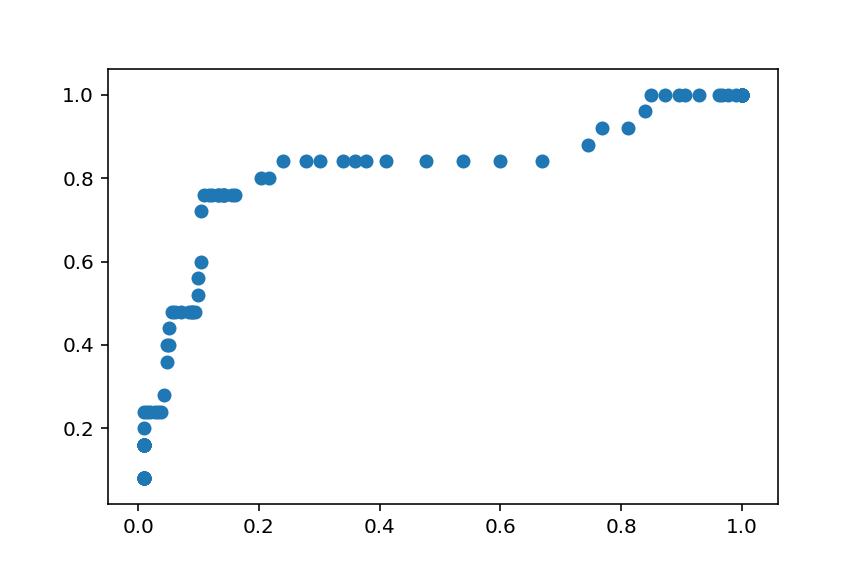

In [94]:
%matplotlib notebook
import matplotlib.pyplot as plt
def AUC(score, truth):
    plot_list = []
    for thre in range(100):
        threshold = thre * 1.0 / 100
        TP = 0
        FN = 0
        FP = 0
        TN = 0
        result = score
        target = np.full_like(result, 1 - threshold)
        result = (np.sign(np.subtract(result, target)) == 1).astype(int)
        for loc, i in enumerate(result):
            if int(truth[loc]) * int(i) == 1:
                TP += 1
            elif int(truth[loc]) == 0 and int(i) == 0:
                TN += 1
            elif int(truth[loc]) == 1 and int(i) == 0:
                FN += 1
            elif int(truth[loc]) == 0 and int(i) == 1:
                FP += 1
        TP_rate = TP * 1.0 / (TP + FN)
        FP_rate = FP * 1.0 / (FP + TN)
        
        plot_list.append((FP_rate, TP_rate))
    return plot_list


def plot_AUC(real_X, real_Y, num):
    score = evaluate(model, real_X[num].to(device)).astype(float)

    result = AUC(score, real_Y[num])
    xs = [x[0] for x in result]
    ys = [x[1] for x in result]
    plt.scatter(xs, ys)
    plt.show()
    
plot_AUC(real_X, real_Y, 10)